AVERAGE SALE PRICE FORECAST
Premises:


> Honey production comes from the amount of colonies and how productive a colony is.

> The average selling price of honey varies according to local production and producers’ stock

> States with less production may have higher average sales values ​​than large producing states






## 0. Start

### 0.0 Imports

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import kurtosis, skew
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
from IPython.display import Image
from IPython.core.display import HTML
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import statsmodels.regression.linear_model as sm
from statsmodels.tools.tools import add_constant


warnings.simplefilter('ignore')

### 0.1 Functions

In [ ]:
from scipy._lib.doccer import indentcount_lines
from pandas.core.dtypes.cast import invalidate_string_dtypes
def descriptive_stats(num_attributes):
  # Central Tedency - mean, median
  ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T 
  ct2 = pd.DataFrame(num_attributes.apply(np.median)).T 

  # Dispersion - std, min, max, range, skew, curtosis
  d1 = pd.DataFrame(num_attributes.apply(np.std)).T
  d2 = pd.DataFrame(num_attributes.apply(min)).T
  d3 = pd.DataFrame(num_attributes.apply(max)).T
  d4 = pd.DataFrame(num_attributes.apply(lambda x : x.max() - x.min())).T
  d5 = pd.DataFrame(num_attributes.apply(lambda x : x.skew())).T
  d6 = pd.DataFrame(num_attributes.apply(lambda x : x.kurtosis())).T

  # Concatenate
  m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
  m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
  return m

def settings():
  %matplotlib inline
  %pylab inline
  plt.style.use('bmh')
  plt.rcParams['figure.figsize'] = [25,12]
  plt.rcParams['font.size'] = 24
  my_cmap = ListedColormap(sns.color_palette("mako").as_hex())
  my_cmap2 = ListedColormap(sns.color_palette("mako_r").as_hex())

  display( HTML('<style>.container { width: 100% !important; }</style>'))
  pd.options.display.max_columns = None
  pd.options.display.max_rows = None
  pd.set_option('display.expand_frame_repr', False)

  sns.set()

def box_dist_plots(target_col, value_col, df, bins = 10):
  plt.subplot(2,2,1)
  sns.boxplot(x = target_col, y = value_col, data = df)

  plt.subplot(2,2,2)
  aux = df[[value_col]]
  sns.histplot(aux)

  plt.subplot(2,2,3)
  aux = df.loc(df[target_col] == 1, value_col)
  sns.histplot(aux, fill=False, element='step', bins=10, color = 'red')

  aux = df.loc(df[target_col] == 0, value_col)
  sns.histplot(aux, fill=False, element='step', bins=10, color = 'green')
  plt.legend(title=value_col, labels=['1', '0'])
  plt.title(value_col);

  plt.subplot(2,2,4)
  aux = df.loc[df[target_col] == 1, value_col]
  sns.histplot(aux, fill=False, element='step', stat='density', bins=10, color='red')

  aux = df.loc[df[target_col] == 0, value_col]
  sns.histplot(aux, fill=False, element='step', stat='density', bins=10, color='green')
  plt.legend(title=value_col, labels=['1', '0'])
  plt.title(value_col);





In [ ]:
settings()

Populating the interactive namespace from numpy and matplotlib


### 0.2 Load Data

A fonte desses dados é Kaggle, e está diponivel no link: https://www.kaggle.com/datasets/mohitpoudel/honey-production-in-us-20102021

In [ ]:
df_raw1 = pd.read_csv('/content/drive/MyDrive/PORTIFOLIO/PRODUÇÃO DE MEL - USA/input/US_honey_production_dataset.csv')
df_raw2 = pd.read_csv('/content/drive/MyDrive/PORTIFOLIO/PRODUÇÃO DE MEL - USA/input/honeyproduction1998-2016 (1).csv')


## 1. Check of Data

### 1.0 Data Description

Meaning of features:

yield_per_colony: It is a measure used in beekeeping to evaluate the amount of honey produced by a bee colony in a given period of time.
It is calculated by dividing the amount of honey produced by the number of bees in the colony.

colony_number: is the number of bee colonies in a certain area.

productions: Total production obtained by multiplying colony_number by yield_per_colony. The unit is pounds

stocks: Refers to stocks held by producers. The unit is pounds

average_price: Refers to the average price per pound based on extended sales. The unit is dollars.

value_of_prod: Production value obtained by multiplying production and average_price. The unit is dollars.

1. The column names in each dataset are different but mean the same thing.
2. The Stock and Productions data of one of the dataset are the same, we will correct it.
3. The column belonging to the average selling price are in different formats in each dataset.
5. The dataset named df_raw1 contains data from 2010 to 2021
6. The df_raw2 dataset contains data from 1998 and 2021.
7. The 'average_price' attribute is formatted differently between datasets.

### 1.1 Data Dimension

In [ ]:
 rows1, col1 = df_raw1.shape
 rows2, col2 = df_raw2.shape

In [ ]:
print('Number of lines of data 1 and 2 respectively:', rows1, 'and', rows2)
print('Number of data columns 1 and 2 respectively:', col1, 'and', col2)

Number of lines of data 1 and 2 respectively: 479 and 785
Number of data columns 1 and 2 respectively: 9 and 8


### 1.2 Data Types

In [ ]:
df_raw1.dtypes

Unnamed: 0            int64
state                object
colony_number         int64
yield_per_colony      int64
productions           int64
stocks                int64
average_price       float64
value_of_prod         int64
year                  int64
dtype: object

In [ ]:
df_raw2.dtypes

state           object
numcol         float64
yieldpercol      int64
totalprod      float64
stocks         float64
priceperlb     float64
prodvalue      float64
year             int64
dtype: object

### 1.3 Check NaN

In [ ]:
df_raw1.isnull().sum()

Unnamed: 0          0
state               0
colony_number       0
yield_per_colony    0
productions         0
stocks              0
average_price       0
value_of_prod       0
year                0
dtype: int64

In [ ]:
df_raw2.isnull().sum()

state          0
numcol         0
yieldpercol    0
totalprod      0
stocks         0
priceperlb     0
prodvalue      0
year           0
dtype: int64

###1.4 Rename Columns

In [ ]:
df_raw2.columns = ['state', 'colony_number', 'yield_per_colony', 'productions', 'stocks',
       'average_price', 'value_of_prod', 'year']

### 1.5 Change Data Types

In [ ]:
df_raw2[['colony_number', 'productions', 'stocks','value_of_prod']] = df_raw2[['colony_number', 'productions', 'stocks', 'value_of_prod']].astype(int)

### 1.6 Delete extra columns

In [ ]:
df_raw1.drop(columns=['Unnamed: 0'], inplace=True)

### 1.7 Standization of Data

In [ ]:
#data incorret, corretion.
df_raw1['productions'] = df_raw1['colony_number'] * df_raw1['yield_per_colony']
df_raw1['average_price'][df_raw1['year'] <= 2017] = df_raw1['average_price'][df_raw1['year'] <= 2017]/100

In [ ]:
df_raw1['state'] = df_raw1['state'].str.replace(' ', '')
df_raw2['state'] = df_raw2['state'].str.replace(' ', '')

### 1.8 Concatenation

In [ ]:
#Concatenate:

df = pd.concat([df_raw1, df_raw2], axis=0)

### 1.9 Check Duplicate Rows

In [ ]:
df.duplicated().sum()

279

### 1.10 Removing Duplicate Rows

In [ ]:
#Removing duplicates
df.drop_duplicates(inplace=True)

In [ ]:
df.sort_values(by='year', inplace=True)

In [ ]:
df.reset_index(drop=True, inplace=True)

### 1.11 Check Again Data Dimension

In [ ]:
rows, col = df.shape

In [ ]:
print('Number of rows :', rows)
print('Number of lines:', col)

Number of rows : 985
Number of lines: year


### 1.12 Descriptive Statistics

**1.12.1 Numerical Attributes**

In [ ]:
num_attributes = df.select_dtypes(include = ['int64', 'float64'])

In [ ]:
stats_table = round(descriptive_stats(num_attributes),2)
stats_table

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,colony_number,2000.00,550000.00,548000.00,62931.98,26000.0,94213.21,2.74,7.88
1,yield_per_colony,19.00,136.00,117.00,58.51,55.0,19.25,0.85,0.76
2,productions,84000.00,46410000.00,46326000.00,4038179.70,1488000.0,6755899.65,3.10,10.50
3,stocks,8000.00,13800000.00,13792000.00,1167324.87,360000.0,2087732.32,3.39,12.81
4,average_price,0.49,8.74,8.25,1.98,1.7,1.18,1.66,3.92
5,value_of_prod,162000.00,83859000.00,83697000.00,5975726.90,2431000.0,9876853.15,3.77,18.13
6,year,1998.00,2021.00,23.00,2009.29,2009.0,6.96,0.04,-1.22


In [ ]:
round(num_attributes.describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99]),2)

,colony_number,yield_per_colony,productions,stocks,average_price,value_of_prod,year
count,985.00,985.00,985.00,985.00,985.00,985.0,985.00
mean,62931.98,58.51,4038179.70,1167324.87,1.98,5975726.9,2009.29
std,94261.07,19.26,6759331.65,2088792.89,1.18,9881870.6,6.96
min,2000.00,19.00,84000.00,8000.00,0.49,162000.0,1998.00
5%,5000.00,33.00,234000.00,41200.00,0.64,413400.0,1999.00
25%,9000.00,45.00,469000.00,108000.00,1.20,1050000.0,2003.00
50%,26000.00,55.00,1488000.00,360000.00,1.70,2431000.0,2009.00
75%,68000.00,70.00,3780000.00,1217000.00,2.38,6050000.0,2015.00
90%,159000.00,85.00,10962000.00,2873800.00,3.64,15746600.0,2019.00
95%,270000.00,94.00,17808000.00,5267200.00,4.23,23557000.0,2020.00


**1.12.1 Categorical Attributes**

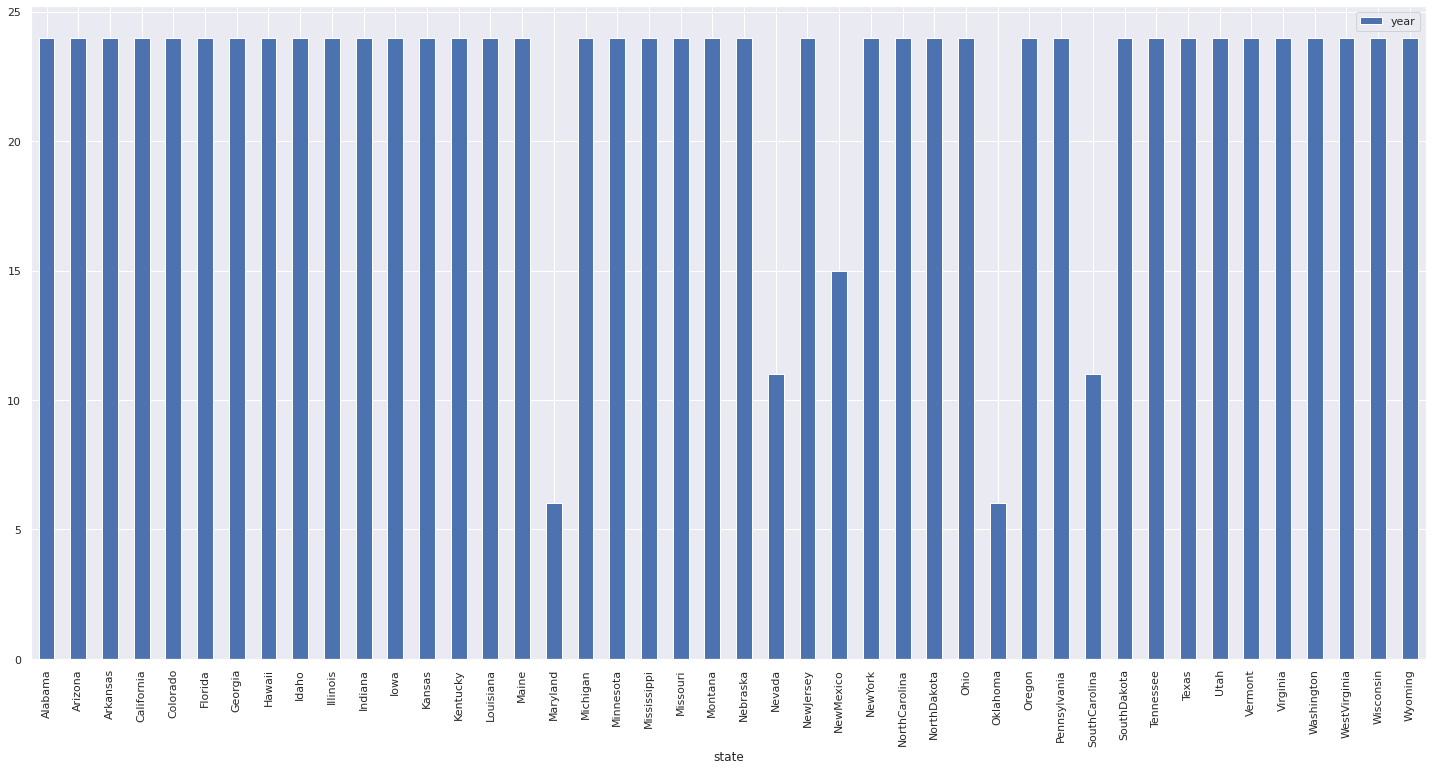

In [ ]:
df[['state', 'year']].groupby('state').count().plot(kind='bar')

**Observation:**

We have some states with little occurrence, which may mean that that state has stopped producing honey. For this reason, I will analyze them and, if there is an interruption, I will remove them from the analysis.

SouthCarolina - **11;**
Oklahoma - **6;**
NewMexico - **15;**
Nevada - **11;**
Maryland - **6.**


**Quick data check**

In [ ]:
df2 = df.copy()

In [ ]:
productions = pd.pivot_table(df2, values='productions', columns=['state'], index=['year'])
productions['mean'] = df2.groupby('year')['productions'].mean()

average_price = pd.pivot_table(df2, values='average_price', columns=['state'], index=['year'])
average_price['mean'] = df2.groupby('year')['average_price'].mean()

def plots(data, estado, name_data):
  plt.plot(data[estado], label = estado)
  plt.plot(data['mean'],label='Global Mean')
  plt.title(f'{name_data} - {estado}')
  plt.xlabel('year')
  plt.legend()

**Visualization**

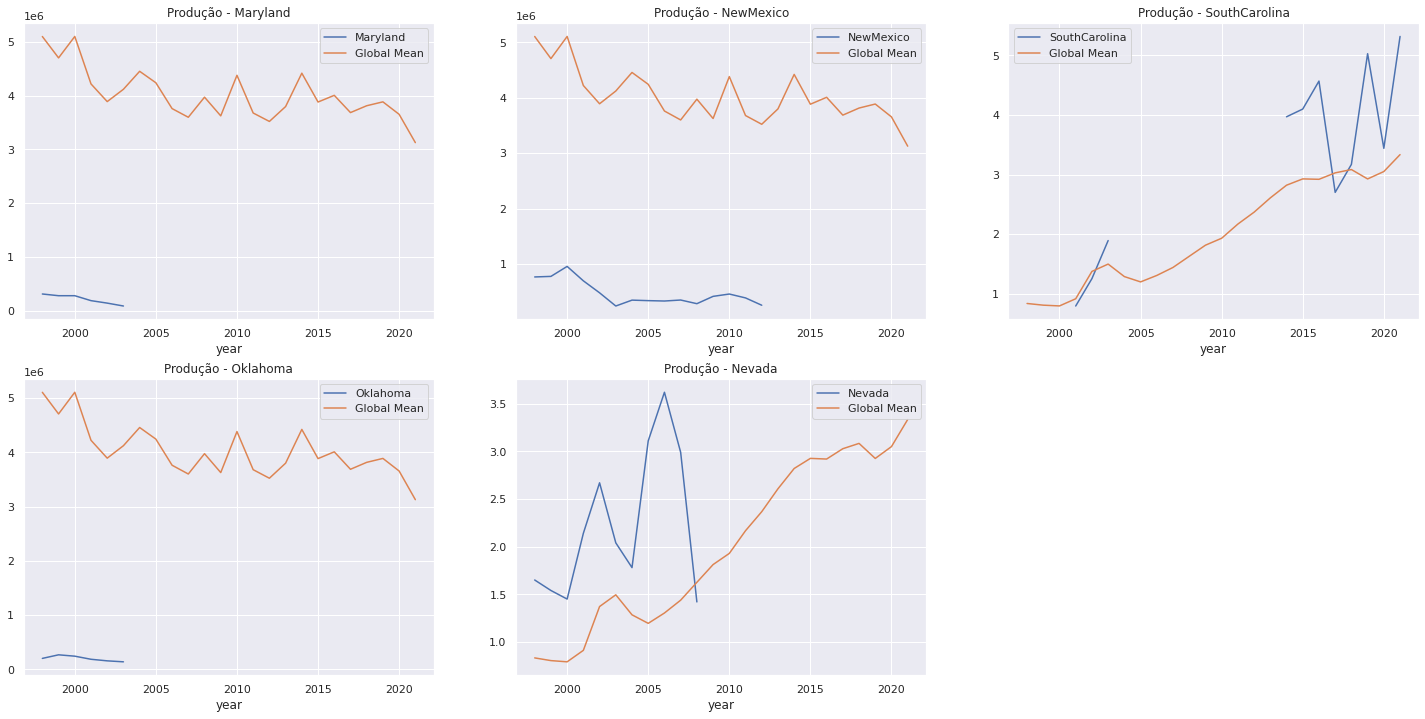

In [ ]:
plt.subplots()

plt.subplot(2, 3, 1)
plots(productions,'Maryland', 'Produção')

plt.subplot(2, 3, 2)
plots(productions,'NewMexico', 'Produção')

plt.subplot(2, 3, 3)
plots(average_price,'SouthCarolina', 'Produção')

plt.subplot(2, 3, 4)
plots(productions,'Oklahoma', 'Produção')

plt.subplot(2, 3, 5)
plots(average_price,'Nevada', 'Produção')



plt.show()

**Observations**:

Maryland, NewMexico and Oklahoma are probably no longer producing honey according to the data.

Nevada and SouthCarolina had their data interrupted and only SouthCarolina had a return.

Analyzing these data, I decided to exclude these states, to improve the consistency of the data.

**Removing the data**

In [ ]:
df2.drop(index=df[(df["state"] == "Maryland") | (df["state"] == "NewMexico") | (df["state"] == "Oklahoma") | (df["state"] == "Nevada")].index, inplace=True)

### 1.13 Quick analisys of describing statistics after remove of the data

In [ ]:
df2.describe()

,colony_number,yield_per_colony,productions,stocks,average_price,value_of_prod,year
count,947.000000,947.000000,9.470000e+02,9.470000e+02,947.000000,9.470000e+02,947.000000
mean,65146.779303,58.904963,4.184958e+06,1.208013e+06,1.990760,6.191837e+06,2009.543823
std,95468.991444,19.447698,6.852973e+06,2.119998e+06,1.192125,1.001783e+07,6.940774
min,3000.000000,19.000000,1.200000e+05,8.000000e+03,0.490000,1.730000e+05,1998.000000
25%,10000.000000,45.000000,5.020000e+05,1.170000e+05,1.200000,1.145000e+06,2003.500000
50%,28000.000000,56.000000,1.656000e+06,3.880000e+05,1.750000,2.544000e+06,2010.000000
75%,71000.000000,70.000000,4.069000e+06,1.259500e+06,2.390000,6.445500e+06,2016.000000
max,550000.000000,136.000000,4.641000e+07,1.380000e+07,8.740000,8.385900e+07,2021.000000


## 2. Feature Enginineering

## 3. EDA

### 3.1. Univariate Analysis

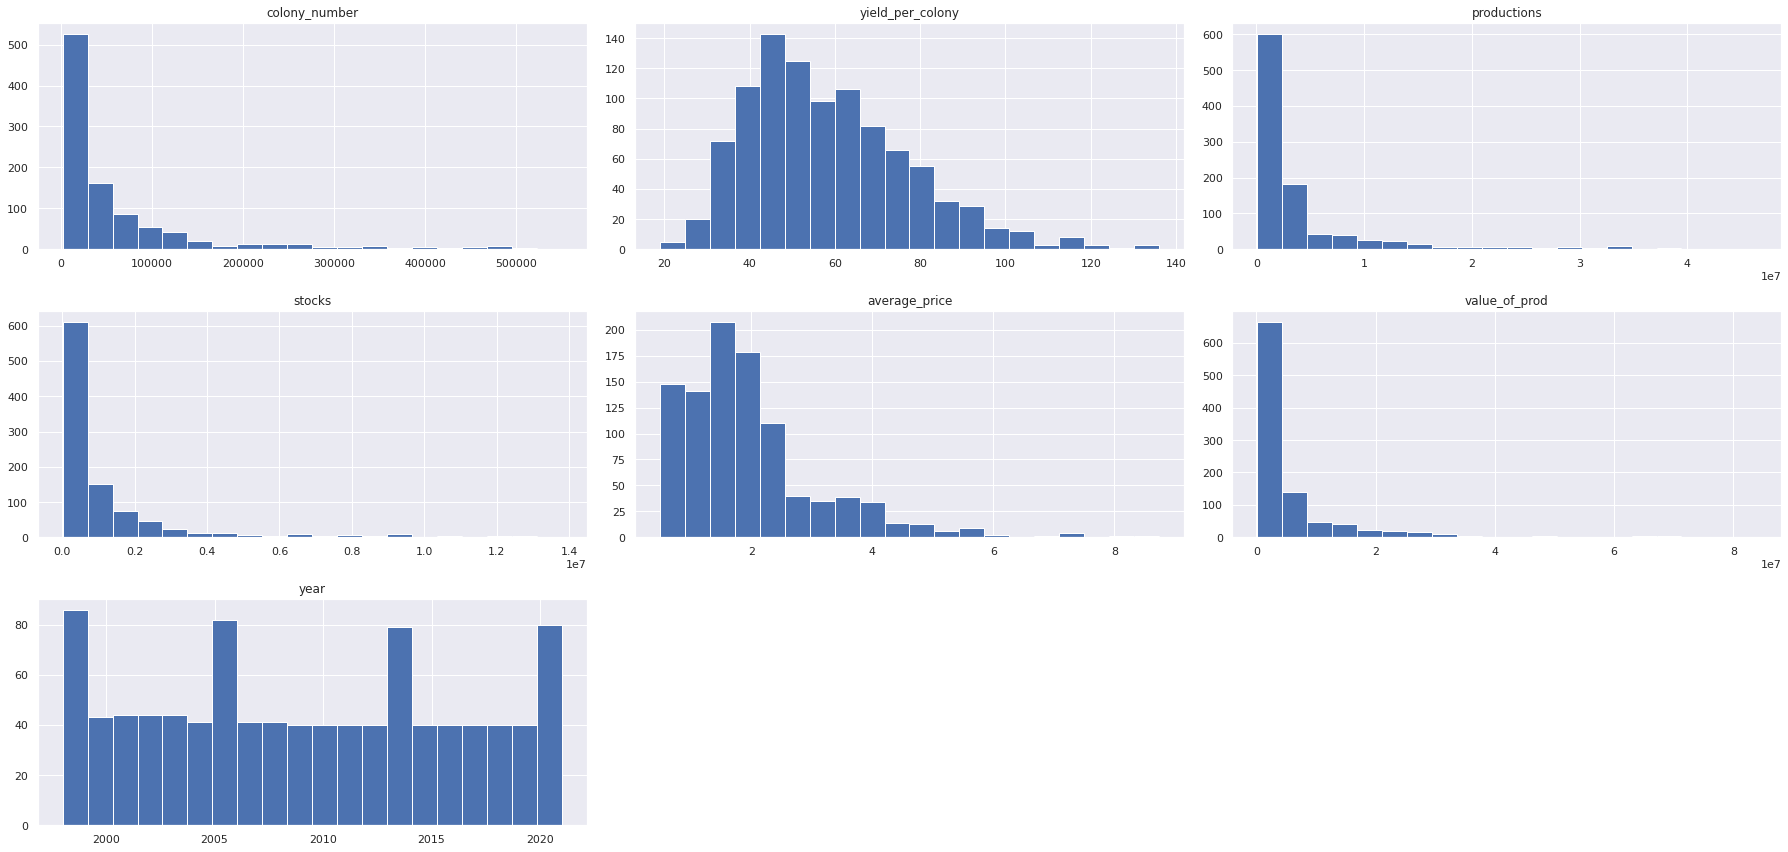

In [ ]:
num_attributes.hist(bins = 20)
plt.tight_layout()

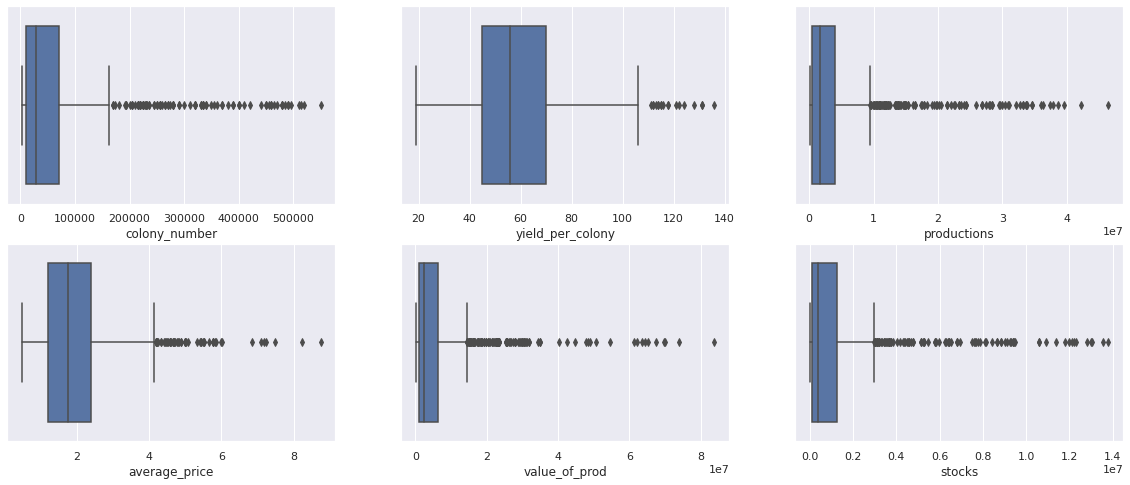

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(20, 8))

sns.boxplot(data = df2, x = 'colony_number', ax=ax1)
sns.boxplot(data = df2, x = 'yield_per_colony', ax=ax2)
sns.boxplot(data = df2, x = 'productions', ax=ax3)
sns.boxplot(data = df2, x = 'average_price', ax=ax4)
sns.boxplot(data = df2, x = 'value_of_prod', ax=ax5)
sns.boxplot(data = df2, x = 'stocks', ax=ax6)

fig.show()

**3.1.1 colony_number**

**Checking the distribution of data by state and year:**


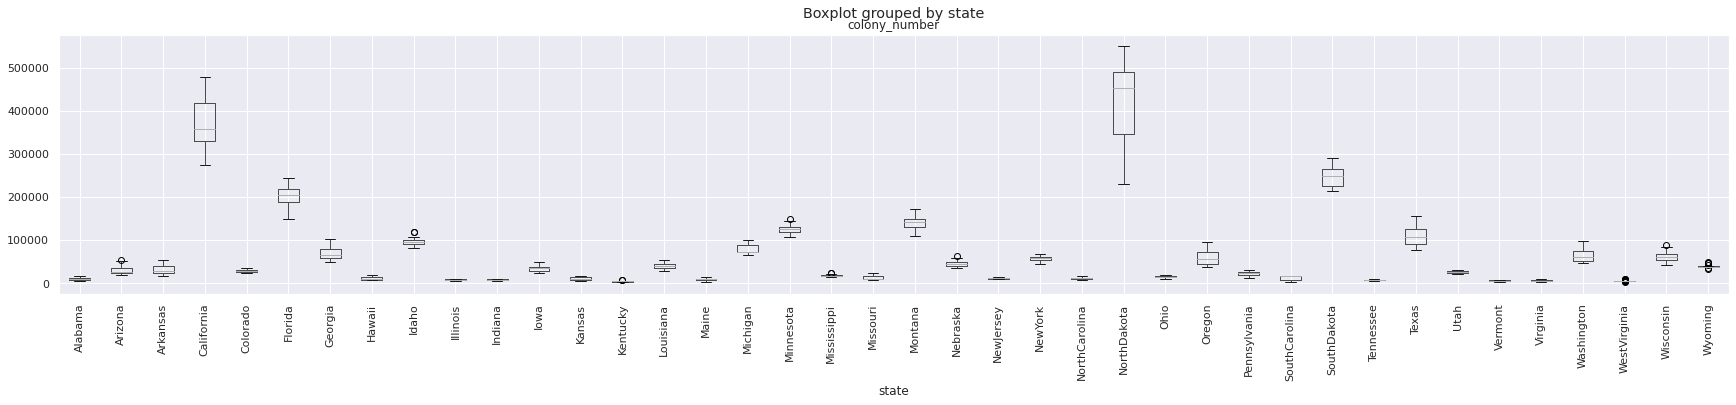

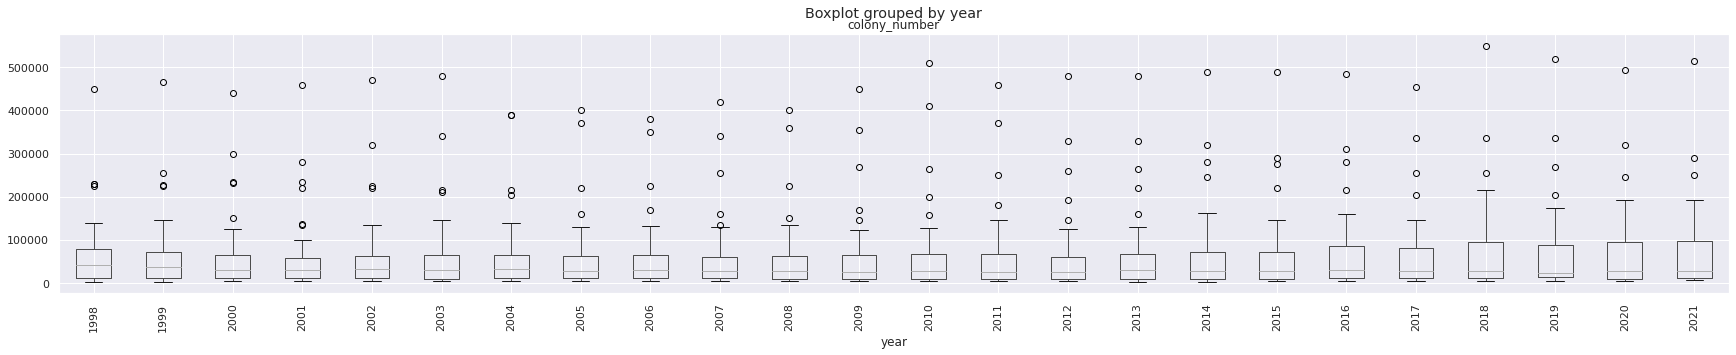

In [ ]:
boxplot = df2.boxplot(column=['colony_number'], by='state',
                          figsize=(29,4.8),
                          layout=(1, 1), rot=90)
boxplot = df2.boxplot(column=['colony_number'], by='year',
                          figsize=(29,4.8),
                          layout=(1, 1), rot=90)

**3.1.2 yield_per_colony**

**Checking the distribution of data by state and year:**

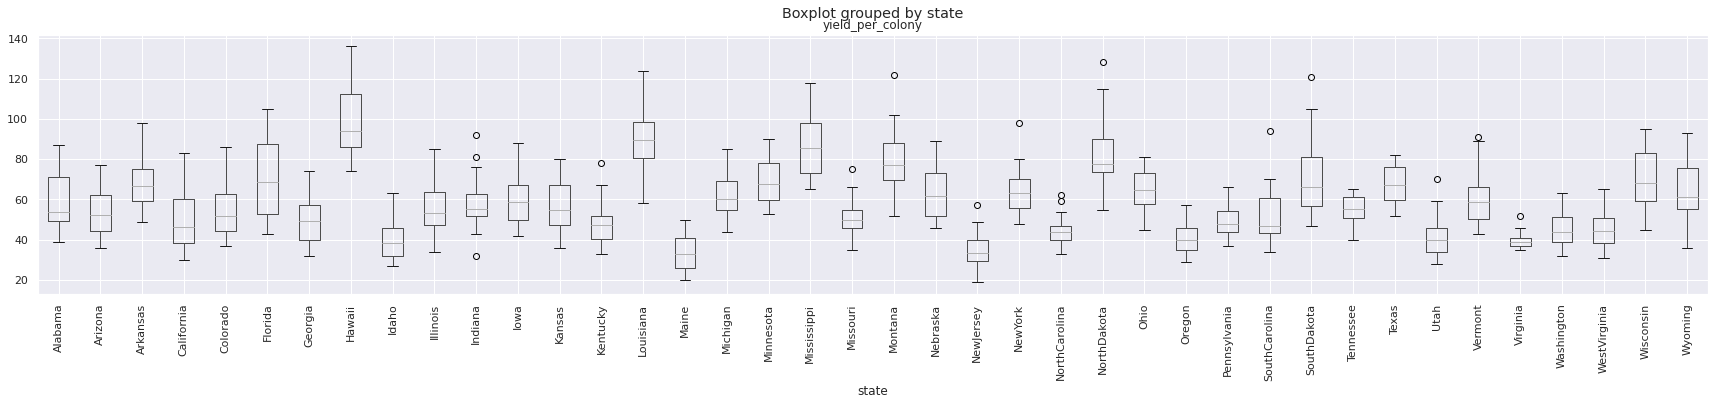

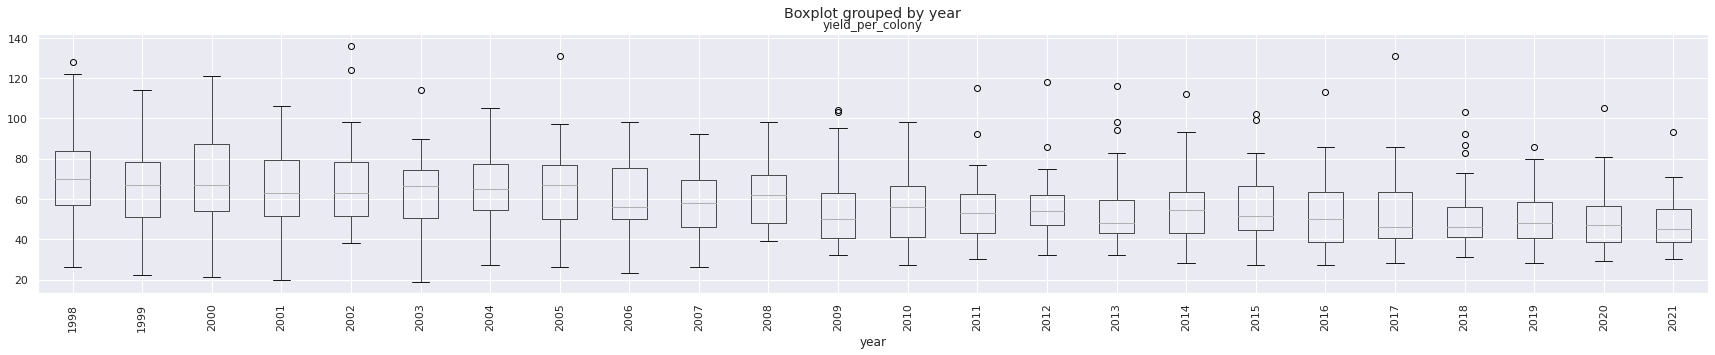

In [ ]:
boxplot = df2.boxplot(column=['yield_per_colony'], by='state',
                          figsize=(29,4.8),
                          layout=(1, 1), rot=90)
boxplot = df2.boxplot(column=['yield_per_colony'], by='year',
                          figsize=(29,4.8),
                          layout=(1, 1), rot=90)

**3.1.3 productions**

**Checking the distribution of data by state and year:**

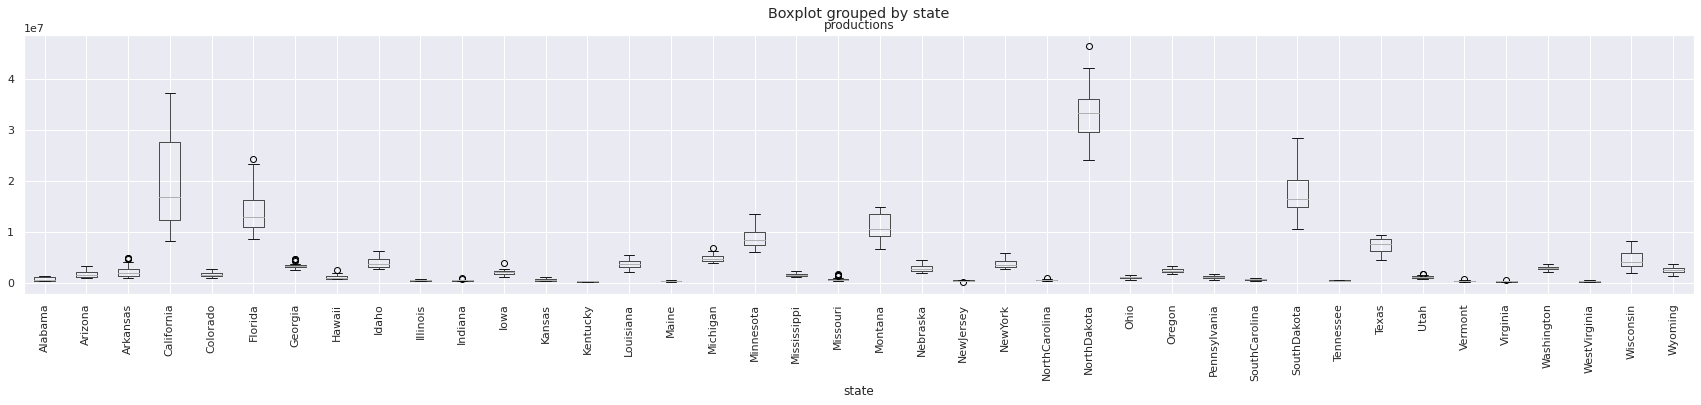

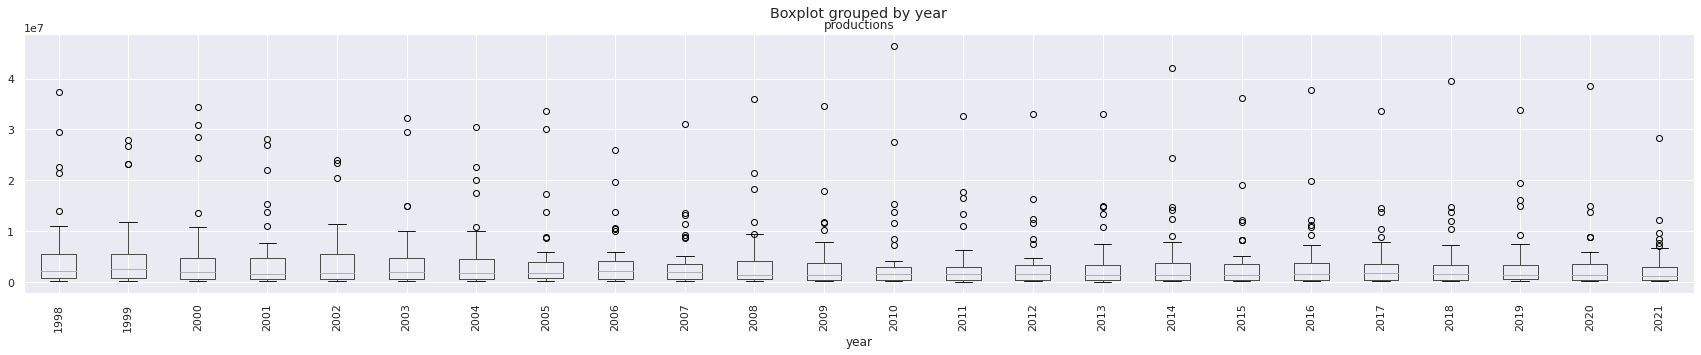

In [ ]:
boxplot = df2.boxplot(column=['productions'], by='state',
                          figsize=(29,4.8),
                          layout=(1, 1), rot=90)
boxplot = df2.boxplot(column=['productions'], by='year',
                          figsize=(29,4.8),
                          layout=(1, 1), rot=90)

**3.1.4 stocks**

**Checking the distribution of data by state and year:**

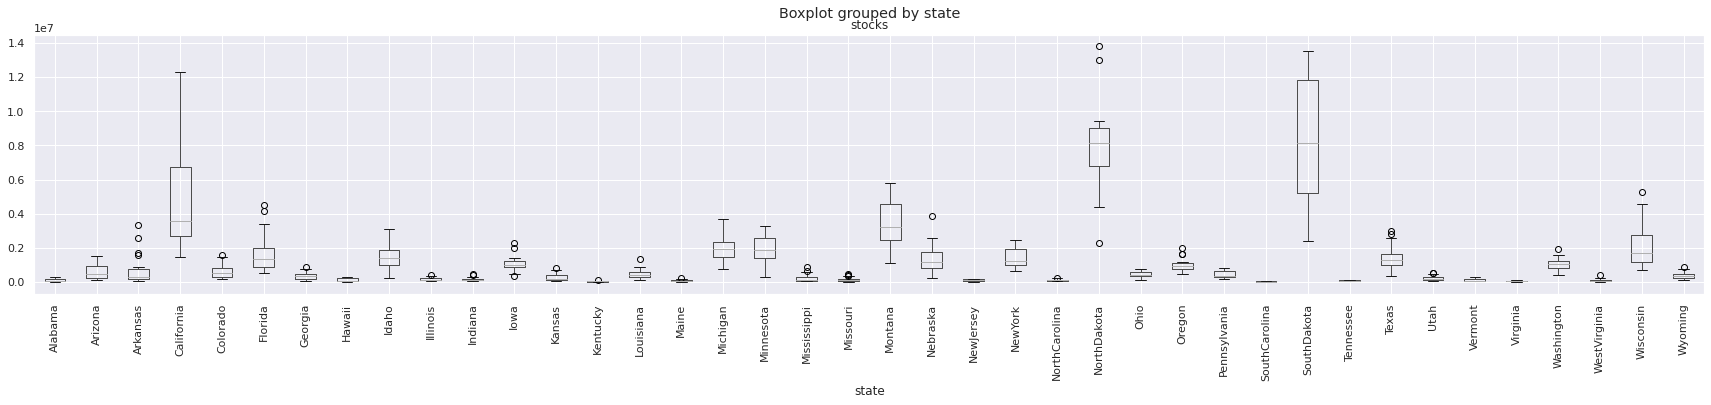

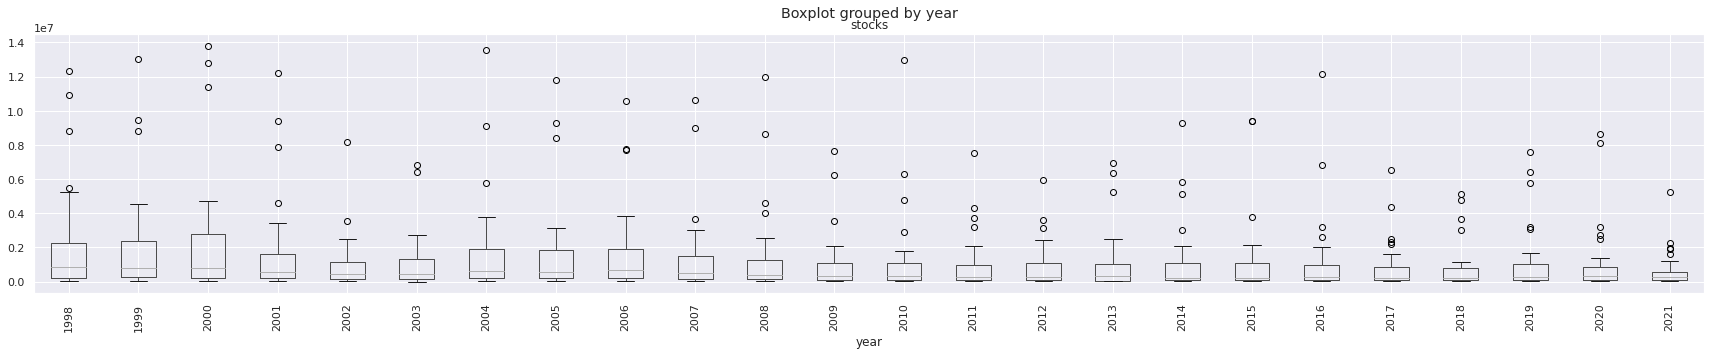

In [ ]:
boxplot = df2.boxplot(column=['stocks'], by='state',
                          figsize=(29,4.8),
                          layout=(1, 1), rot=90)
boxplot = df2.boxplot(column=['stocks'], by='year',
                          figsize=(29,4.8),
                          layout=(1, 1), rot=90)



**3.1.5 average_price**

**Checking the distribution of data by state and year:**

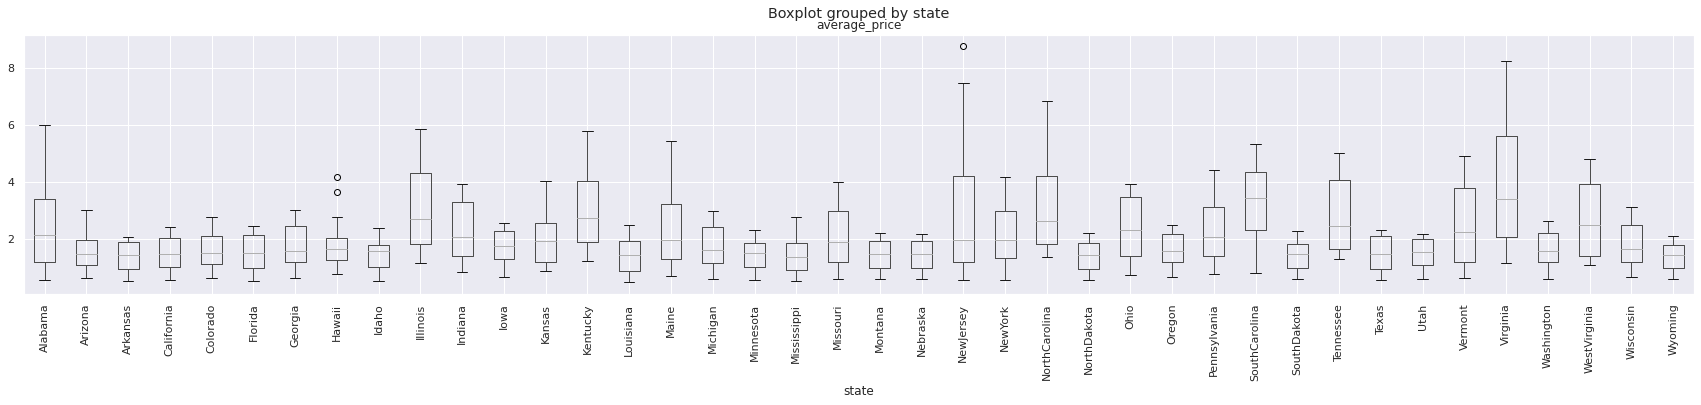

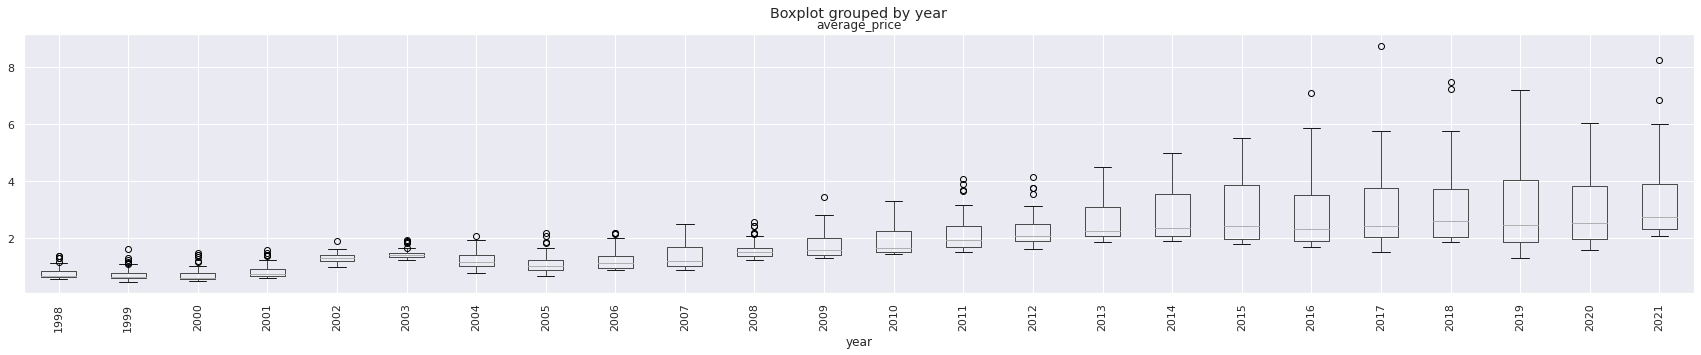

In [ ]:
boxplot = df2.boxplot(column=['average_price'], by='state',
                          figsize=(29,4.8),
                          layout=(1, 1), rot=90)
boxplot = df2.boxplot(column=['average_price'], by='year',
                          figsize=(29,4.8),
                          layout=(1, 1), rot=90)


**3.1.5 value_of_prod**

**Checking the distribution of data by state and year:**

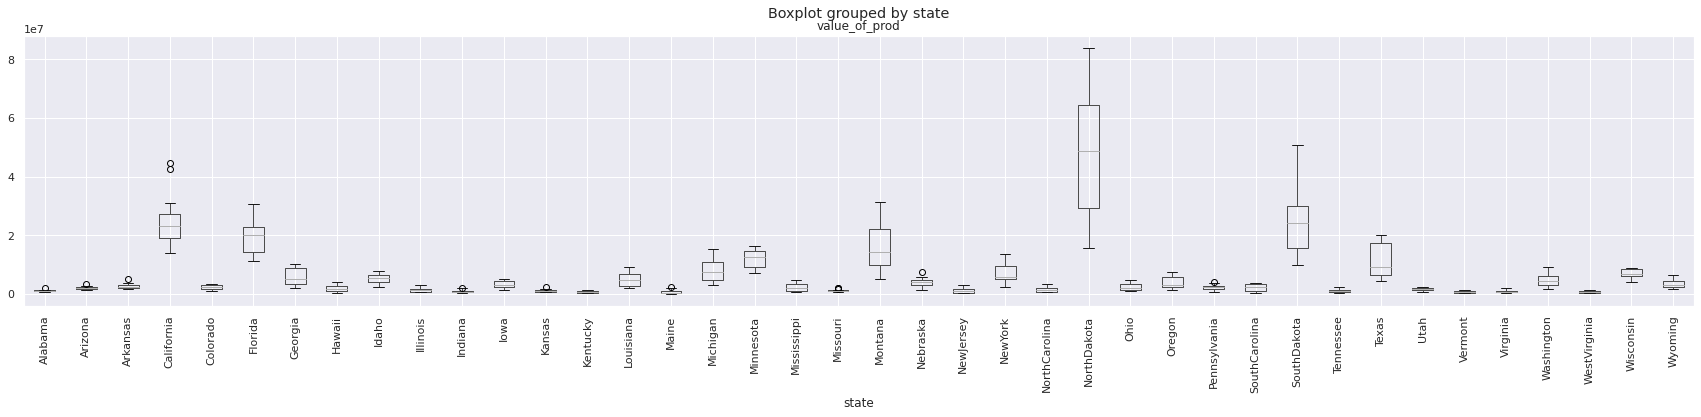

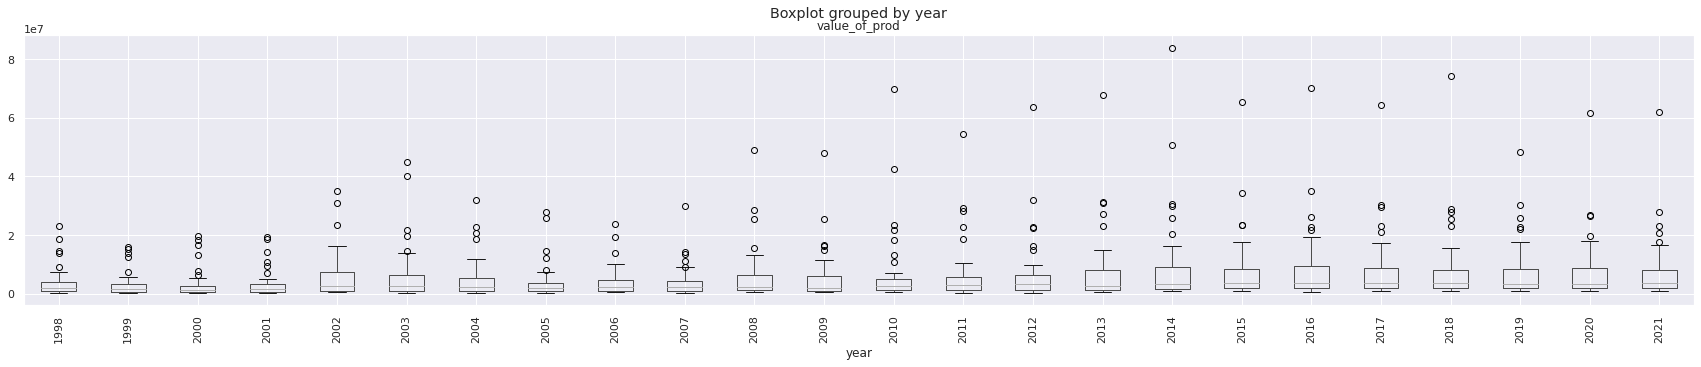

In [ ]:
boxplot = df2.boxplot(column=['value_of_prod'], by='state',
                          figsize=(29,5),
                          layout=(1, 1), rot=90);

boxplot = df2.boxplot(column=['value_of_prod'], by='year',
                          figsize=(29,5),
                          layout=(1, 1), rot=90);

### 3.2. Multivariate Analysis

In [ ]:
df3 = df2.copy()

**3.2.1 Pairplot**

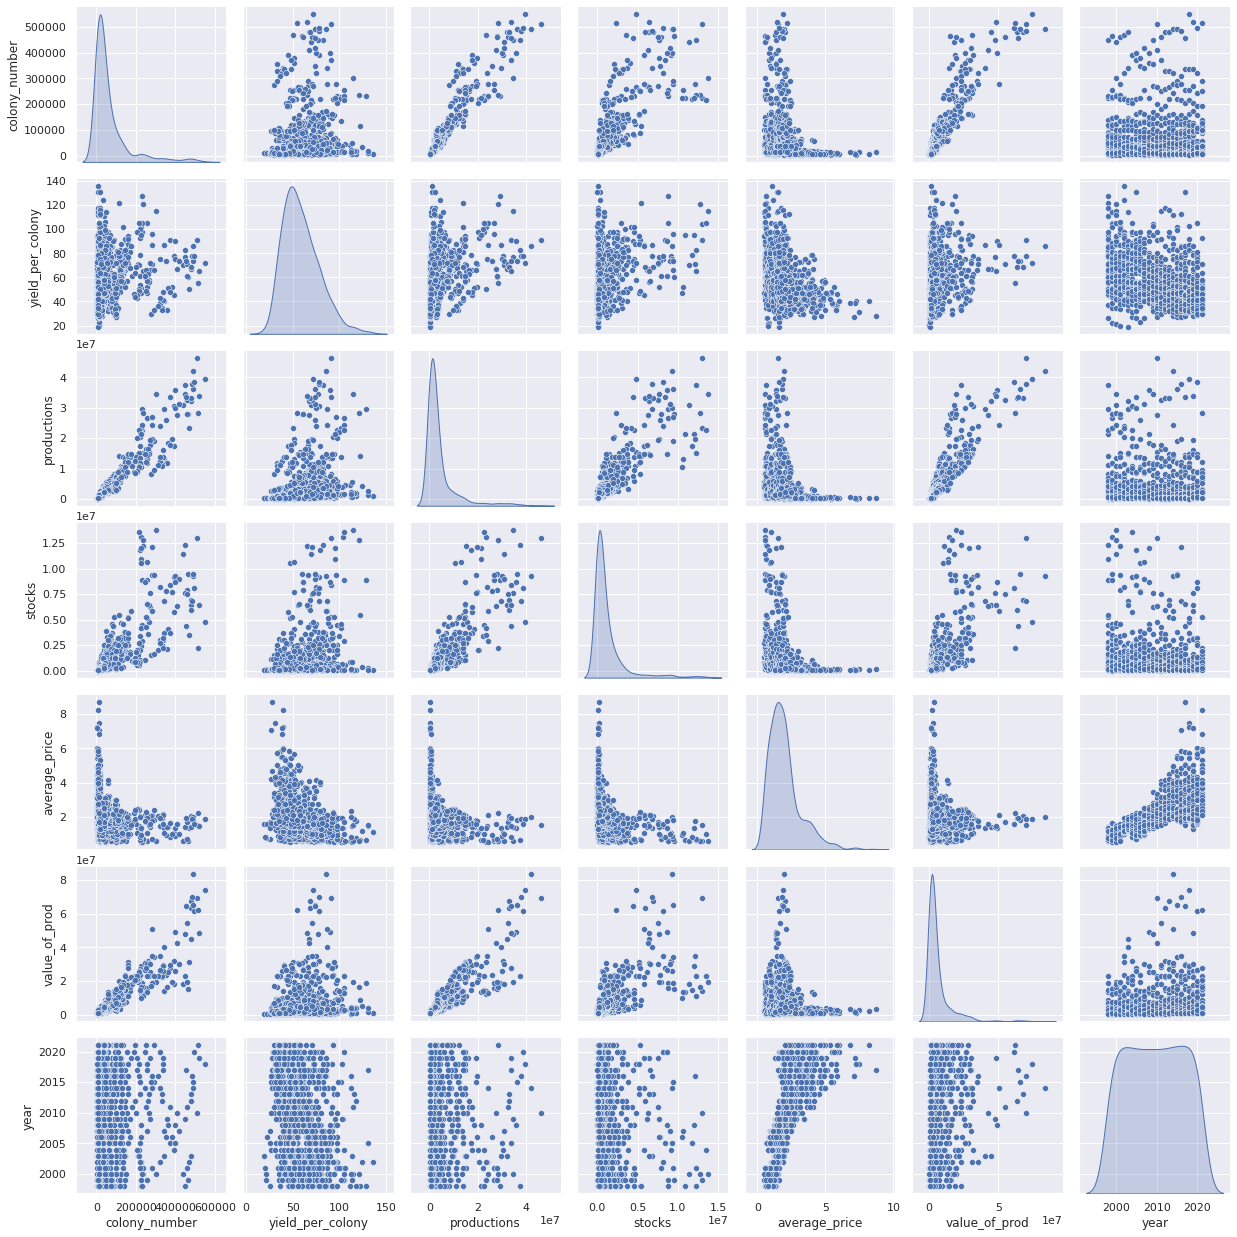

In [ ]:
sns.pairplot(df3, diag_kind="kde")

**3.2.2 - Hypothesis: States with high number of colonies tend to have the most honey productions, but don't necessarily have the best productivity.**

In [ ]:
prod = df3.groupby('state', as_index=False)['productions','yield_per_colony'].mean().sort_values(by='productions', ascending=False)
round(prod.head(10),2)

,state,productions,yield_per_colony
25,NorthDakota,33268333.33,82.17
3,California,19049791.67,49.21
30,SouthDakota,17396500.00,70.96
5,Florida,14320708.33,70.75
20,Montana,11072583.33,78.75
17,Minnesota,8772083.33,68.88
32,Texas,7388541.67,67.75
16,Michigan,4845291.67,62.29
38,Wisconsin,4446500.00,69.96
8,Idaho,3966958.33,40.17


In [ ]:
yield_per = df3.groupby('state', as_index=False)['yield_per_colony','productions'].mean().sort_values(by='yield_per_colony', ascending=False)
round(yield_per.head(10),2)

,state,yield_per_colony,productions
7,Hawaii,98.88,1118625.00
14,Louisiana,90.25,3646958.33
18,Mississippi,87.71,1565541.67
25,NorthDakota,82.17,33268333.33
20,Montana,78.75,11072583.33
30,SouthDakota,70.96,17396500.00
5,Florida,70.75,14320708.33
38,Wisconsin,69.96,4446500.00
17,Minnesota,68.88,8772083.33
2,Arkansas,68.62,2271958.33


Among the 10 states with the highest productions, 6 of them rank as the states with the colonies with the highest yields per colony.

**3.2.3 Hypothesis: Colony yields are falling over the years and the number of colonies is increasing, is there a correlation between the variables?**

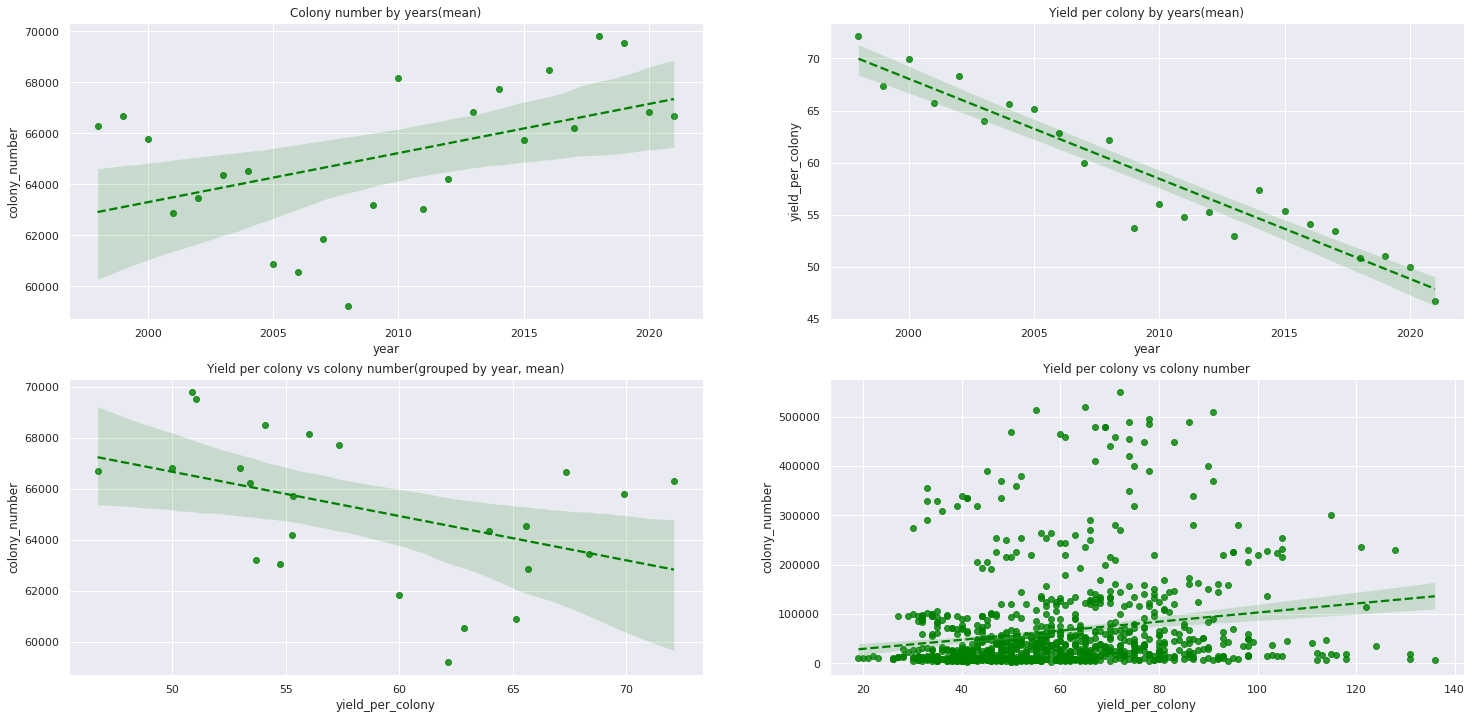

In [ ]:
hip_mean = df3.groupby('year', as_index=False)['yield_per_colony', 'colony_number'].mean()
fig, ((ax, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2)

sns.regplot(x="year", y='colony_number', line_kws={"linestyle": "--"}, data=hip_mean, scatter=True,ax=ax, color='green')
sns.regplot(x="year", y='yield_per_colony', line_kws={"linestyle": "--"}, data=hip_mean, scatter=True,ax=ax1, color='green')
sns.regplot(x="yield_per_colony", y='colony_number', line_kws={"linestyle": "--"}, data=hip_mean, scatter=True,ax=ax2, color='green')
sns.regplot(x="yield_per_colony", y='colony_number', line_kws={"linestyle": "--"}, data=df2, scatter=True,ax=ax3, color='green')

ax.set_title("Colony number by years(mean)")
ax1.set_title("Yield per colony by years(mean)")
ax2.set_title("Yield per colony vs colony number(grouped by year, mean)")
ax3.set_title("Yield per colony vs colony number")


plt.show()

There is a negative correlation between the variables over the years, which may imply that producers are increasing the number of colonies to compensate for the loss of yield, or that the increase in the number of colonies causes the yield to fall. However, we must be aware that correlation does not imply causality.

**3.2.4 - Year x all Grouped by mean**



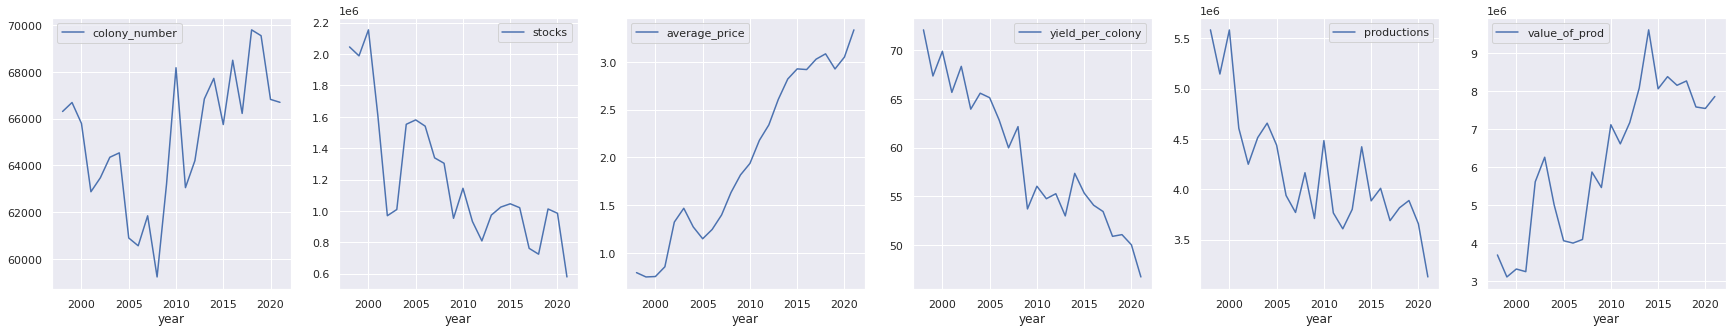

In [ ]:
fig, (ax, ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=1, ncols=6, figsize=(30, 5))

df3.groupby('year', as_index=False)['colony_number'].mean().plot(x='year', y='colony_number',ax=ax);

df3.groupby('year', as_index=False)['stocks'].mean().plot(x='year', y='stocks',ax=ax1);

df3.groupby('year', as_index=False)['average_price'].mean().plot(x='year', y='average_price',ax=ax2);

df3.groupby('year', as_index=False)['yield_per_colony'].mean().plot(x='year', y='yield_per_colony',ax=ax3);

df3.groupby('year', as_index=False)['productions'].mean().plot(x='year', y='productions',ax=ax4);

df3.groupby('year', as_index=False)['value_of_prod'].mean().plot(x='year', y='value_of_prod',ax=ax5);

### 3.3 Correlation

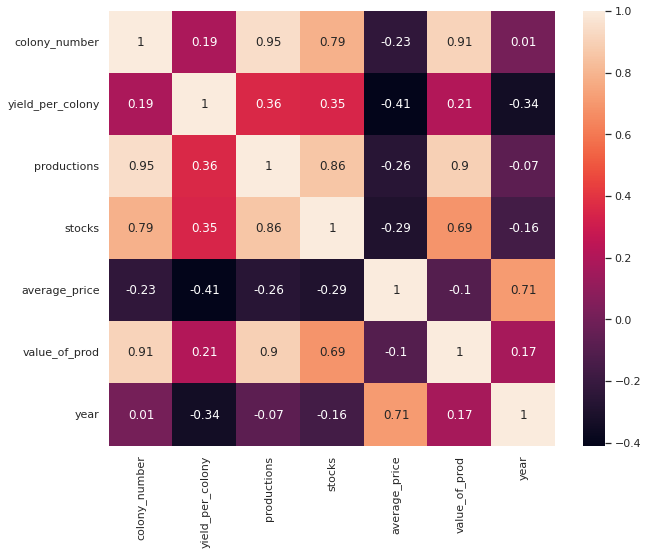

In [ ]:
corr = df3.corr(method='pearson')
plt.figure(figsize=(10,8))
sns.heatmap(round(corr,2), annot=True)

## 4. Machine Learning

### 4.1 Preprocessing

In [ ]:
df4 = df3.copy()

**4.1.1 Splitting our data.**

In [ ]:
X = df4[['state', 'colony_number', 'yield_per_colony', 'productions', 'stocks', 'year']]
y = df4['average_price']

**4.1.2 Encoding of Categorical Variables**

In [ ]:
# Encode Label para os atributos year e state

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X.state =le.fit_transform(X.state.values)
X.year = le.fit_transform(X.year.values)

In [ ]:
#Checking the transformation
X.head()

,state,colony_number,yield_per_colony,productions,stocks,year
0,13,3000,50,150000,51000,0
1,0,16000,71,1136000,159000,0
2,23,65000,80,5200000,2444000,0
3,24,8000,59,472000,151000,0
4,25,230000,128,29440000,8832000,0


**4.1.3 Splitting in training and testing**

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=1,
                                                    test_size=.2,
                                                    stratify=X['state'])

**4.1.4 Normalization of numerical data**

In [ ]:
# Normalization by z-score
# applying the normalization
ct = ColumnTransformer([("z-score-norm", StandardScaler(), slice(1, 5))])
X_train.iloc[:, 1:5] = ct.fit_transform(X_train)
X_test.iloc[:, 1:5] = ct.transform(X_test)

**4.1.5 Visualization of the distribution of training and test data**

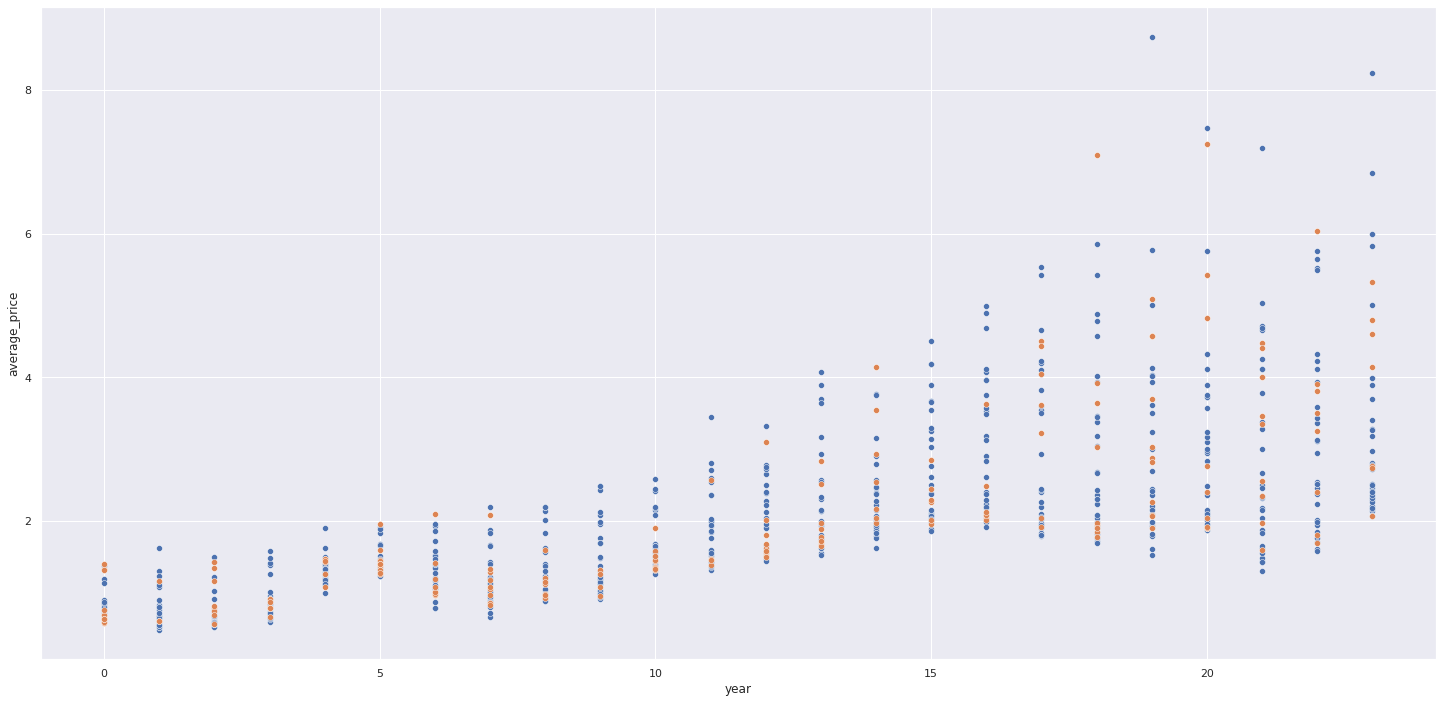

In [ ]:
sns.scatterplot(x = X_train['year'], y = y_train)
sns.scatterplot(x = X_test['year'], y = y_test)

### 4.2 Model 01 - Linear Regression

In [ ]:
# Fitting multiple linear regression
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

**4.2.1 Prediction and Evaluation**


In [ ]:
# Prediction
y_pred = regressor.predict(X_test)

In [ ]:
# RMSE
RMSE = np.sqrt(((y_test - y_pred)**2).mean())
print('RMSE = %.1f' % RMSE)

RMSE = 0.8


**4.2.2 Project baseline**

For comparison purposes, it is very common to use a standard model (baseline) for performance evaluation. In linear regression, the baseline is a model that always predicts the average of the observed values. For this model, the RMSE is given by:

In [ ]:
# RMSE
RMSE_baseline = np.sqrt(((y_test - y_train.mean())**2).mean())
print('RMSE baseline = %.1f' % RMSE_baseline)

RMSE baseline = 1.3


In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print('R-square = %.3f' % r2)

R-square = 0.630


**4.2.3 Attribute selection - backward elimination**

In [ ]:
# building optimal model using backward elimination

# novos X_train e X_test
X_train_sm = add_constant(X_train)
X_test_sm = add_constant(X_test)

Considering a significance level of **5%**, we will start modeling with all attributes. Then, the variable that has the highest probability P>|t| will be deleted from X_opt and the process will restart.

In [ ]:
# all features
# i_map = {0: 'constant',
#          1: 'state',
#          2: 'colony_number',
#          3: 'yield_per_colony',
#          4: 'productions',
#          5: 'stocks',
#          6: 'year'}
X_opt = X_train_sm.iloc[:, [0, 1, 2, 3, 4, 5, 6]]
regressor_OLS = sm.OLS(endog=y_train, exog=X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          average_price   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     183.2
Date:                Tue, 27 Dec 2022   Prob (F-statistic):          2.76e-143
Time:                        19:02:33   Log-Likelihood:                -853.38
No. Observations:                 757   AIC:                             1721.
Df Residuals:                     750   BIC:                             1753.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.6052      0.074      8.136      0.000       0.459       0.751
state                0.0044      0.002      1.769      0.077      -0.000       0.009
colony_number       -0.8534      0.102     -8.373      0.000      -1.054      -0.653
yield_per_colony    -0.2953      0.036     -8.151      0.000      -0.366      -0.224
productions          0.7158      0.119      6.013      0.000       0.482       0.949
stocks              -0.0689      0.056     -1.225      0.221      -0.179       0.041
year                 0.1117      0.004     25.750      0.000       0.103       0.120
==============================================================================
Omnibus:                      323.359   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2179.414
Skew:                           1.791   Prob(JB):                         0.00
Kurtosis:                      10.501   Cond. No.                         141.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# Option 1 - remove index 5
X_opt = X_train_sm.iloc[:, [0, 1, 2, 3, 4, 6]]
regressor_OLS = sm.OLS(endog=y_train, exog=X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          average_price   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     219.4
Date:                Tue, 27 Dec 2022   Prob (F-statistic):          3.73e-144
Time:                        19:04:32   Log-Likelihood:                -854.13
No. Observations:                 757   AIC:                             1720.
Df Residuals:                     751   BIC:                             1748.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.6040      0.074      8.117      0.000       0.458       0.750
state                0.0039      0.002      1.592      0.112      -0.001       0.009
colony_number       -0.8480      0.102     -8.324      0.000      -1.048      -0.648
yield_per_colony    -0.2945      0.036     -8.127      0.000      -0.366      -0.223
productions          0.6510      0.107      6.102      0.000       0.442       0.861
year                 0.1127      0.004     26.362      0.000       0.104       0.121
==============================================================================
Omnibus:                      321.702   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2152.478
Skew:                           1.782   Prob(JB):                         0.00
Kurtosis:                      10.452   Cond. No.                         135.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# Option 2 - remove index 5, 6
X_opt = X_train_sm.iloc[:, [0, 1, 2, 3, 4]]
regressor_OLS = sm.OLS(endog=y_train, exog=X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          average_price   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     52.25
Date:                Tue, 27 Dec 2022   Prob (F-statistic):           7.40e-39
Time:                        19:05:11   Log-Likelihood:                -1102.1
No. Observations:                 757   AIC:                             2214.
Df Residuals:                     752   BIC:                             2237.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.9403      0.076     25.689      0.000       1.792       2.089
state                0.0019      0.003      0.560      0.576      -0.005       0.009
colony_number       -0.5955      0.141     -4.234      0.000      -0.872      -0.319
yield_per_colony    -0.5519      0.048    -11.405      0.000      -0.647      -0.457
productions          0.4474      0.148      3.032      0.003       0.158       0.737
==============================================================================
Omnibus:                      208.535   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              633.364
Skew:                           1.338   Prob(JB):                    2.93e-138
Kurtosis:                       6.595   Cond. No.                         122.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# Option 3 - remove index 5, 6 and 1
X_opt = X_train_sm.iloc[:, [0, 2, 3, 4]]
regressor_OLS = sm.OLS(endog=y_train, exog=X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          average_price   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     69.63
Date:                Tue, 27 Dec 2022   Prob (F-statistic):           9.50e-40
Time:                        19:05:39   Log-Likelihood:                -1102.3
No. Observations:                 757   AIC:                             2213.
Df Residuals:                     753   BIC:                             2231.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.9769      0.038     52.270      0.000       1.903       2.051
colony_number       -0.6129      0.137     -4.471      0.000      -0.882      -0.344
yield_per_colony    -0.5574      0.047    -11.770      0.000      -0.650      -0.464
productions          0.4651      0.144      3.229      0.001       0.182       0.748
==============================================================================
Omnibus:                      209.150   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              637.006
Skew:                           1.341   Prob(JB):                    4.74e-139
Kurtosis:                       6.606   Cond. No.                         7.56
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

For X_opt = X.iloc**[:, [0, 2, 3, 4]]**, all coefficients are within the specified significance level. However, Adj. R-squared decreases in relation to the model with X_opt = X.iloc**[:, [0, 1, 2, 3, 4, 6]]**, which in turn had one of its coefficients slightly above the level of 5% significance.

Therefore we will use X_opt = X.iloc**[:, [0, 1, 2, 3, 4, 6]]** in our analyses..


**4.2.4 Prediction and Evaluation**

In [ ]:
# X optimal - option 1
X_train = X_train_sm.iloc[:, [0, 1, 2, 3, 4, 6]]
X_test = X_test_sm.iloc[:, [0, 1, 2, 3, 4, 6]]

regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

# RMSE
rmse = np.sqrt(((y_test - y_pred)**2).mean())
print('RMSE = %.1f' % rmse)

# R2
r2 = r2_score(y_test, y_pred)
print('R-square = %.3f' % r2)

RMSE = 0.8
R-square = 0.630


**4.2.5 Conclusion**

The best result was the optimization of Option 1, keeping the values ​​with all attributes, but this model showed us that stock has no relevance for predicting values.

Our Baseline has moved to **RMSE: 0.8** and **R2: 0.63**

###4.3 Model 02 - Random Forest

**4.3.1 Splitting train and test**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=1,
                                                    test_size=.2,
                                                    stratify=X['state'])

**4.3.2 Model**

In [ ]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

**4.3.3 Feature importances**

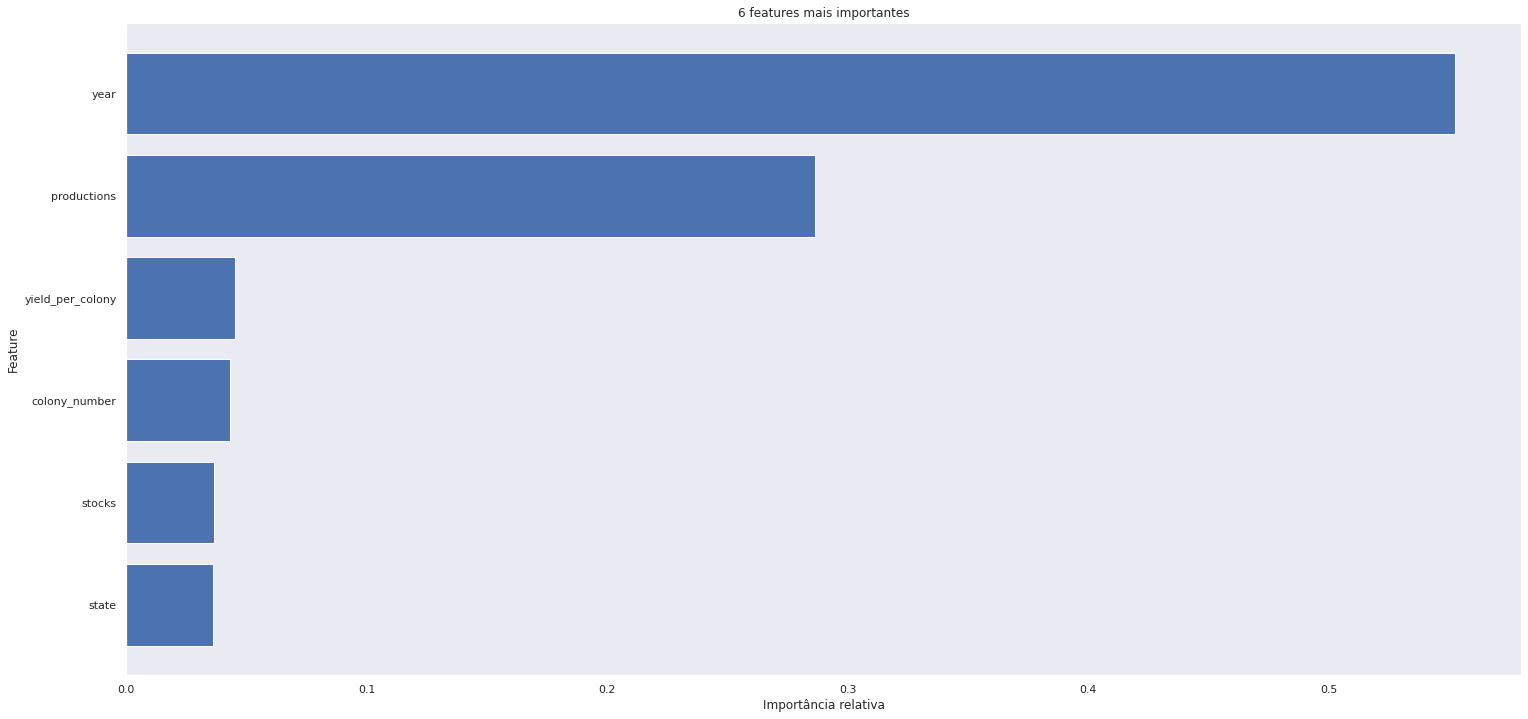

In [ ]:
# feature importances
fp = rf_model.feature_importances_
n = 6
i = np.argsort(fp)[-n:]
cols = X_train.columns
plt.barh(cols[i], fp[i])
plt.grid()
plt.title(f"{n} features most relevance")
plt.xlabel("Relative importance")
plt.ylabel("Feature")
plt.show()

**4.3.4 Prediction and Evaluation**

In [ ]:
# prediction
y_pred = rf_model.predict(X_test)
y_pred_train = rf_model.predict(X_train)

In [ ]:
# error test and train
mse_train = mean_squared_error(y_true=y_train, y_pred=y_pred_train)
mse_test = mean_squared_error(y_true=y_test, y_pred=y_pred)

print(f"RMSE train: {np.sqrt(mse_train)}")
print(f"RMSE test: {np.sqrt(mse_test)}")

RMSE de treino: 0.18585693390645816
RMSE de teste: 0.5104029596412292


**4.3.5 GridSearch**

In [ ]:
# Definition of parameters
# grid search and cross validation

# number of trees
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 800, num = 5)]

# number of attributes in each division
max_features = ['auto', 'sqrt']

# profundidade máxima de cada árvore
max_depth = [int(x) for x in np.linspace(10, 100, num = 5)]
max_depth.append(None)

# maximum depth of each tree
min_samples_split = [2, 5, 10]

# minimum number of observations on a sheet
min_samples_leaf = [1, 2, 4]

# search grid: 5*2*6*3*3 = 540 instances
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [ ]:
# instantiating grid search
grid_search = GridSearchCV(estimator = rf_model, param_grid = param_grid, 
                           cv = 5, n_jobs = -1, verbose = 2,
                           scoring='neg_mean_squared_error')

In [ ]:
# fit
#grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [10, 32, 55, 77, 100, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 237, 425, 612, 800]},
             scoring='neg_mean_squared_error', verbose=2)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,

             param_grid={'max_depth': [10, 32, 55, 77, 100, None],

                         'max_features': ['auto', 'sqrt'],

                         'min_samples_leaf': [1, 2, 4],

                         'min_samples_split': [2, 5, 10],

                         'n_estimators': [50, 237, 425, 612, 800]},
                         
             scoring='neg_mean_squared_error', verbose=2)

**4.3.6 Best params**



In [ ]:
#grid_search.best_params_

{'max_depth': 100,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 800}

**4.3.7 Best model**

In [ ]:
best_model = grid_search.best_estimator_

**4.3.8 Prediction and Evaluation**

In [ ]:
# prediction
y_pred = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)

In [ ]:
# error train and test
mse_train = mean_squared_error(y_true=y_train, y_pred=y_pred_train)
mse_test = mean_squared_error(y_true=y_test, y_pred=y_pred)

print(f"RMSE de treino: {np.sqrt(mse_train)}")
print(f"RMSE de teste: {np.sqrt(mse_test)}")

RMSE de treino: 0.16928942788252502
RMSE de teste: 0.4855725517696338


In [ ]:
r2 = r2_score(y_test, y_pred)
print('R-square = %.3f' % r2)

R-square = 0.852


### 4.3 Conclusion

How the model 02 have doing better results with **R-square: 0.852** and **RMSE: 0.485** the baseline project has been updated.

Future analysis with Decision Tree and MLPRegressor